# Prédiction Qualité de l'aire et de la Pollution
# Outline
- [ 1 - Packages et global paraméters](#1)
- [ 2 - Qualité de l'air](#2)
  - [ 2.1 Etude liée à une commune](#2.1)
      - [ 2.1.1 Chargement et visualisation des données](#2.1.1)
      - [ 2.1.2 Modèle Sarima](#2.1.2)
      - [ 2.1.4 LSTM](#2.1.4)
      - [ 2.1.5 Evaluations](#2.1.5)
- [ 3 - Episode de pollution constaté l'année passée](#3)
  - [ 3.1 Chargement et visualisation des données](#3.1)
  - [ 3.2 Prediction du polluant](#3.2)
  - [ 3.3 Prediction de l'état de la pollution](#3.3)
- [ 4 - Episode de pollution constaté la veille le jour même et prévu le lendemain](#4)
  - [ 3.1 Chargement et visualisation des données](#4.1)
  - [ 3.2 Prediction du polluant](#4.2)
  - [ 3.3 Prediction de l'état de la pollution](#4.3)

<a name="1"></a>
## 1 - Packages et global paraméters

In [311]:
from utils import * #S'assurer que le fichier utils.py est dans le même repertoire
import numpy as np
import pandas as pd
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
import seaborn as snc
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.regularizers import l2
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [312]:
aire_quality = "./data/climat_france.aire_quality.csv"
polution_113 = "./data/climat_france.pollution_113.csv"
polution_114 = "./data/climat_france.pollution_114.csv"

<a name="2"></a>
## 2 - Air quality

In [313]:
id_data = 112

<a name="2.1"></a>
###   2.1 Etude sur une commune

In [314]:
# Choix d'un code zone au hasard
code_zone = "2001"

<a name="2.1.1"></a>
#### 2.1.1 Chargement et visualisation des données
- hypothèse : $x_{t+1} = f(x_t, x_{t-1}, \ldots)$, avec x : code_qual et t:date_ech
- Charger -> prétraiter -> Visualiser(décrire) --> corriger éventuellement variation saisonnières (Moyenne mobile/LR)


In [315]:
init_data = get_data_by_code_zone(aire_quality ,code_zone)

In [316]:
print("dimension des données initiales", init_data.shape)

dimension des données initiales (1346, 18)


In [317]:
init_data.tail()

,_id,gml_id,aasqa,date_maj,partition_field,code_no2,code_o3,code_pm10,code_pm25,code_qual,code_so2,code_zone,coul_qual,date_dif,date_ech,lib_qual,lib_zone,source
1341,65dfdb2d63ab081ada5232b8,976171829,32,2024-02-26 12:28:55.289000+00:00,322024w8,1,2,1,1,2,1,2001,#50CCAA,26/02/2024,25/02/2024,Moyen,ABBECOURT,Atmo HDF
1345,65dfdb2d63ab081ada5232bc,980136471,32,2024-02-27 12:36:04.209000+00:00,322024w9,1,2,1,1,2,1,2001,#50CCAA,27/02/2024,26/02/2024,Moyen,ABBECOURT,Atmo HDF
1344,65dfdb2d63ab081ada5232bb,982440369,32,2024-02-28 12:01:05.622000+00:00,322024w9,1,2,1,1,2,1,2001,#50CCAA,28/02/2024,29/02/2024,Moyen,ABBECOURT,Atmo HDF
1342,65dfdb2d63ab081ada5232b9,982440367,32,2024-02-28 12:01:05.622000+00:00,322024w9,1,2,1,2,2,1,2001,#50CCAA,28/02/2024,27/02/2024,Moyen,ABBECOURT,Atmo HDF
1343,65dfdb2d63ab081ada5232ba,982440368,32,2024-02-28 12:01:05.622000+00:00,322024w9,1,2,1,2,2,1,2001,#50CCAA,28/02/2024,28/02/2024,Moyen,ABBECOURT,Atmo HDF


In [318]:
# Mise à jour des données initiales.
data = update_zone_info(init_data, id_data, code_zone)

la date la plus recénte avant mise à jour : 2024-02-28 12:01:05.622000+00:00
Les données ont été mises à jour avec succès.
32 récentes observations on été ajouté


In [319]:
data.shape # taille initiale des données

(1378, 18)

In [320]:
print("dimension après maj", data.shape)

dimension après maj (1378, 18)


In [321]:
data.tail(5) # verifier qu'on a les dernières dans le champ date_maj

,_id,gml_id,aasqa,date_maj,partition_field,code_no2,code_o3,code_pm10,code_pm25,code_qual,code_so2,code_zone,coul_qual,date_dif,date_ech,lib_qual,lib_zone,source
1373,NaN,1093585231,32,2024-03-29 12:32:59.737000+00:00,322024w13,1,2,1,1,2,1,2001,#50CCAA,2024/03/29,2024-03-28,Moyen,ABBECOURT,Atmo HDF
1374,NaN,1097357083,32,2024-03-30 12:11:10.381000+00:00,322024w13,1,2,1,1,2,1,2001,#50CCAA,2024/03/30,2024-03-29,Moyen,ABBECOURT,Atmo HDF
1376,NaN,1101066882,32,2024-03-31 11:05:58.821000+00:00,322024w13,1,2,1,1,2,1,2001,#50CCAA,2024/03/31,2024-03-31,Moyen,ABBECOURT,Atmo HDF
1375,NaN,1101066881,32,2024-03-31 11:05:58.821000+00:00,322024w13,1,2,1,1,2,1,2001,#50CCAA,2024/03/31,2024-03-30,Moyen,ABBECOURT,Atmo HDF
1377,NaN,1101066883,32,2024-03-31 11:05:58.821000+00:00,322024w14,1,2,1,1,2,1,2001,#50CCAA,2024/03/31,2024-04-01,Moyen,ABBECOURT,Atmo HDF


In [322]:
# Suppression de la colonne id car crée par mongo
data = data.drop('_id', axis=1)
# Suppression des lignes avec des dates dupliquées
unique_date_ech = data.drop_duplicates(subset=['date_ech'])
unique_date_ech.nunique()

gml_id             1145
aasqa                 2
date_maj            846
partition_field     170
code_no2              3
code_o3               5
code_pm10             5
code_pm25             5
code_qual             4
code_so2              2
code_zone             2
coul_qual             4
date_dif            840
date_ech           1145
lib_qual              4
lib_zone              1
source                1
dtype: int64

In [323]:
len(unique_date_ech)

1145

In [324]:
nb_dup, unique_date_ech = remove_duplicates(unique_date_ech)
print(nb_dup)

0


In [325]:
unique_date_ech = unique_date_ech[['code_no2', 'code_o3', 'code_pm10', 'code_pm25', 'code_so2', 'code_qual', 'date_ech']]

In [326]:
# Échantillonner les dates par fenetre (jour/semaine/mois...), 
fenetre_echantillonage = 7 # on echantillone par mois, mais peut être changé, initialement on a par jour. 
df_resampled = resample_by_day(unique_date_ech, fenetre_echantillonage)

In [327]:
df_resampled.shape

(170, 6)

In [328]:
training_set, test_set = split_train_test_set(df_resampled, 0.2)
training_set.head()

,code_no2,code_o3,code_pm10,code_pm25,code_so2,code_qual
date_ech,,,,,,
2021-01-02,1.0,2.0,2.0,2.0,1.0,2.0
2021-01-09,1.0,2.0,1.0,1.0,1.0,2.0
2021-01-16,1.0,2.0,1.0,1.0,1.0,2.0
2021-01-23,1.0,2.0,1.0,2.0,1.0,2.0
2021-01-30,1.0,2.0,1.0,2.0,1.0,2.0


In [329]:
training_set.tail(5)

,code_no2,code_o3,code_pm10,code_pm25,code_so2,code_qual
date_ech,,,,,,
2023-07-08,1.0,2.0,1.0,1.0,1.0,2.0
2023-07-15,1.0,2.0,1.0,1.0,1.0,2.0
2023-07-22,1.0,2.0,1.0,1.0,1.0,2.0
2023-07-29,1.0,2.0,1.0,1.0,1.0,2.0
2023-08-05,1.0,2.0,1.0,1.0,1.0,2.0


In [330]:
print("taille training set", len(training_set))
print("taille test set", len(test_set))

taille training set 136
taille test set 34


In [331]:
print(f"Les dimensions : training_set : {training_set.shape},"+
      f"test_set : {test_set.shape}")

Les dimensions : training_set : (136, 6),test_set : (34, 6)


In [332]:
training_set = training_set.apply(interpolate)
test_set = test_set.apply(interpolate)

Text(0.5, 0, 'date_ech')

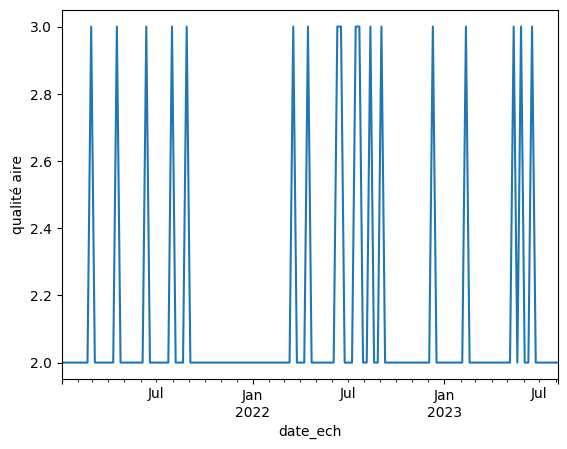

In [333]:
#df_resampled.set_index("date_ech", inplace=True)
training_set[['code_qual']].plot(legend=False)
ax = plt.gca()
ax.set_ylabel('qualité aire')
ax.set_xlabel('date_ech')

<a name="2.1.2"></a>
#### 2.1.2 Modèle Sarima
- Prévision basée sur modèle aléatoire tels que Sarima.
- hypothèse : on a une série temporelle qui présente une saisonnalité

In [334]:
def predict_and_plot_zone(code_zone ,air_quality_data):
    # Initialiser et entraîner le modèle SARIMA sur toutes les données
    order = (1, 1, 1)  # Ordre des composants ARIMA
    seasonal_order = (1, 1, 1, 14)  # Période saisonnière (7 jours dans ce cas)
    model = SARIMAX(air_quality_data, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)

    # Prédire les valeurs pour une semaine
    start_date = air_quality_data.index[-1] + timedelta(days=1)
    end_date = start_date + timedelta(days=6)
    #predictions = results.predict(test_set["code_qual"])
    predictions = results.forecast(steps=len(test_set)).round()

    # Créer le DataFrame des prédictions
    predictions_sarima = pd.DataFrame({"Date": predictions.index, "Prediction": predictions.values})

    # Afficher le DataFrame des prédictions
    display(predictions_sarima)
    
    # Plot en barres avec marqueurs ronds en haut
    plt.figure(figsize=(12, 6))
    plt.bar(predictions_sarima["Date"], predictions_sarima["Prediction"], color="lightblue", label="Prédictions")
    plt.scatter(predictions_sarima["Date"], predictions_sarima["Prediction"], color="red", marker="o", label="Marqueurs")
    plt.title(f"Prédictions pour la zone {code_zone}")
    plt.xlabel("Date")
    plt.ylabel("Indice de Qualité de l'Air")
    plt.legend()
    plt.grid(True)
    plt.show()
    return predictions_sarima

,Date,Prediction
0,2023-08-12,2.0
1,2023-08-19,2.0
2,2023-08-26,2.0
3,2023-09-02,2.0
4,2023-09-09,2.0
5,2023-09-16,2.0
6,2023-09-23,2.0
7,2023-09-30,2.0
8,2023-10-07,2.0
9,2023-10-14,2.0


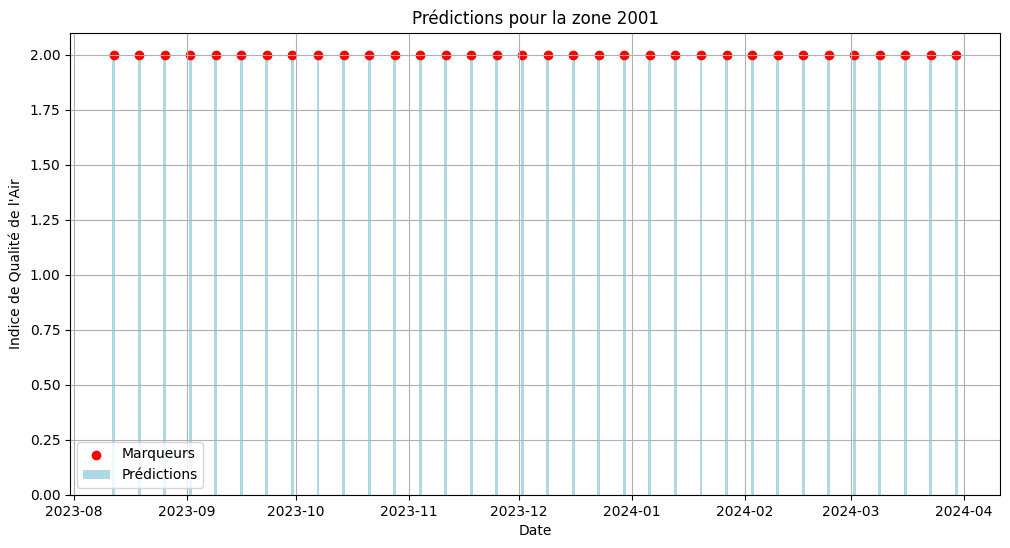

In [335]:
predictions_sarima = predict_and_plot_zone(code_zone,training_set[['code_qual']])

In [336]:
evaluate_predictions(test_set, predictions_sarima)

Mean Absolute Error (MAE): 0.029411764705882353
Mean Squared Error (MSE): 0.029411764705882353
R^2 Score: -0.030303030303030498


*Contribution des prédicteurs*

<a name="2.1.3"></a>
#### 2.1.3 Neural Network

NameError: name 'y_test' is not defined

<a name="2.1.4"></a>
#### 2.1.4 LSTM

In [131]:
# Préparation des données pour le LSTM
def prepare_data(data, n_features):
    """
    Convertir le DataFrame en un format compatible avec le LSTM.
    Args:
    - data (DataFrame): Le DataFrame contenant les séries temporelles.
    - n_features (int): Nombre de caractéristiques par pas de temps.
    
    Returns:
    - X (numpy array): Les entrées du modèle.
    - y (numpy array): Les sorties du modèle.
    """
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:(i + 1), :n_features])
        y.append(data[i + 1, -1])
    return np.array(X), np.array(y)

In [154]:
# Assurez-vous que 'date_ech' est de type datetime si ce n'est pas déjà fait
training_set.index = pd.to_datetime(training_set.index)
test_set.index = pd.to_datetime(test_set.index)

# Extraire les caractéristiques temporelles
training_set['day_of_week'] = training_set.index.dayofweek
training_set['day_of_month'] = training_set.index.day
training_set['month'] = training_set.index.month

test_set['day_of_week'] = test_set.index.dayofweek
test_set['day_of_month'] = test_set.index.day
test_set['month'] = test_set.index.month


# Séparation des features et de la cible
features = ['code_no2', 'code_o3', 'code_pm10', 'code_pm25', 'code_so2', 'day_of_week', 'day_of_month', 'month']
target = ['code_qual']
# Extraction des matrices des features et des cibles
X_train_raw = training_set[features].values
y_train_raw = training_set[target].values
X_test_raw = test_set[features].values
y_test_raw = test_set[target].values

# Normalisation Z-score des features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)

# Normalisation Z-score de la cible
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)


print(f"NaN dans l'ensemble d'entraînement: {np.isnan(X_train).any()}")
print(f"NaN dans l'ensemble de test: {np.isnan(X_test).any()}")

NaN dans l'ensemble d'entraînement: False
NaN dans l'ensemble de test: False


In [155]:
# Création du modèle LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], y_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Prédiction sur l'ensemble de test
predictions = model.predict(X_test)


Epoch 1/100
5/5 - 10s - 2s/step - loss: 3.3457 - val_loss: 2.4209
Epoch 2/100
5/5 - 0s - 55ms/step - loss: 2.9849 - val_loss: 2.1281
Epoch 3/100
5/5 - 0s - 74ms/step - loss: 2.6209 - val_loss: 1.8317
Epoch 4/100
5/5 - 0s - 53ms/step - loss: 2.1258 - val_loss: 1.6218
Epoch 5/100
5/5 - 0s - 65ms/step - loss: 2.2933 - val_loss: 1.4856
Epoch 6/100
5/5 - 0s - 38ms/step - loss: 1.6799 - val_loss: 1.3089
Epoch 7/100
5/5 - 0s - 39ms/step - loss: 1.5973 - val_loss: 1.1509
Epoch 8/100
5/5 - 0s - 38ms/step - loss: 1.5422 - val_loss: 1.0310
Epoch 9/100
5/5 - 0s - 72ms/step - loss: 1.3752 - val_loss: 0.9299
Epoch 10/100
5/5 - 0s - 39ms/step - loss: 1.3189 - val_loss: 0.8387
Epoch 11/100
5/5 - 0s - 40ms/step - loss: 1.3156 - val_loss: 0.7651
Epoch 12/100
5/5 - 0s - 37ms/step - loss: 1.0965 - val_loss: 0.6989
Epoch 13/100
5/5 - 0s - 38ms/step - loss: 1.0337 - val_loss: 0.6363
Epoch 14/100
5/5 - 0s - 40ms/step - loss: 1.0226 - val_loss: 0.5822
Epoch 15/100
5/5 - 0s - 46ms/step - loss: 0.9030 - val_los

In [156]:
# Inversion de la normalisation pour les prédictions dans l'échelle d'origine
predictions = scaler_y.inverse_transform(predictions)

# Inversion de la normalisation pour  les vraies valeurs de y dans l'échelle d'origine
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Évaluation du modèle
print("Mean Squared Error:", mean_squared_error(y_test, predictions))
print("Mean Absolute Error:", mean_absolute_error(y_test, predictions))
print("R^2 Score:", r2_score(y_test, predictions))


Mean Squared Error: 0.02785121434067485
Mean Absolute Error: 0.04216795809128705
R^2 Score: 0.024363521884238404


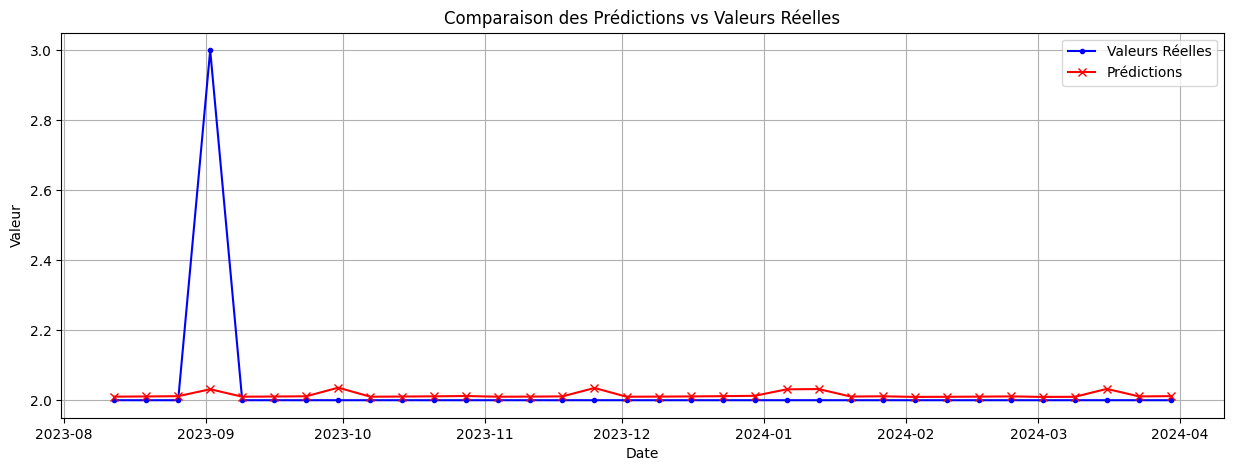

In [157]:
def plot_predictions_vs_true(date_ech, y_test, predictions):
    plt.figure(figsize=(15, 5))
    plt.plot(date_ech, y_test, label='Valeurs Réelles', marker='.', color='blue')
    plt.plot(date_ech, predictions, label='Prédictions', marker='x', color='red')
    plt.title('Comparaison des Prédictions vs Valeurs Réelles')
    plt.xlabel('Date')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_predictions_vs_true(test_set.index, y_test, predictions)


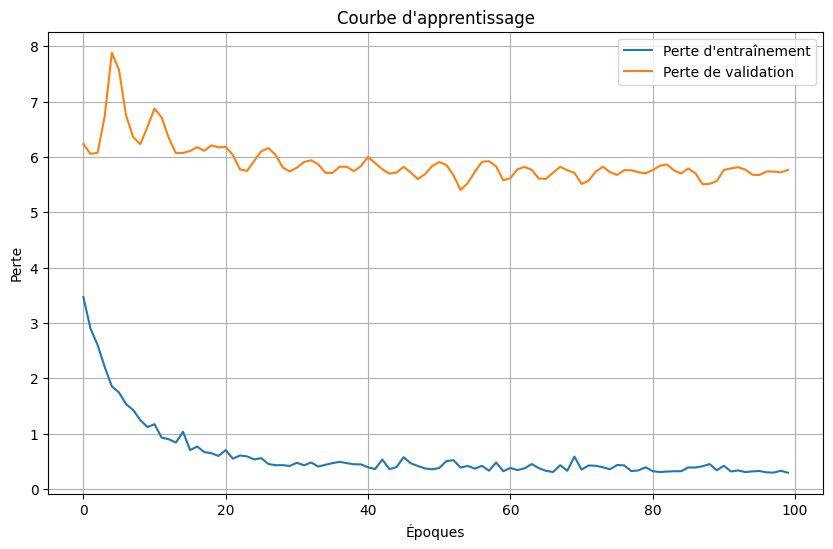

In [145]:
def plot_learning_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Perte d\'entraînement')
    plt.plot(history.history['val_loss'], label='Perte de validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.title('Courbe d\'apprentissage')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_learning_curve(history)

<a name="3"></a>
## 2 - Pollution 113

In [339]:
id_pol = 113

In [340]:
# Choix d'un code zone au hasard
code_zone = "2003"

In [341]:
init_data = get_data_by_dep(polution_113 ,code_zone)

In [342]:
print("dimension des données initiales", init_data.shape)

dimension des données initiales (48, 12)


In [343]:
init_data.head(30)

,_id,gml_id,aasqa,date_maj,partition_field,lib_pol,lib_zone,etat,date_ech,date_dif,code_zone,code_pol
28,65dff4e9a44b3486ecfbe0a0,3471623,84,2024-02-28 13:37:05.299000+00:00,842023w34,O3,Bassin Lyon Nord-Isère,INFORMATION ET RECOMMANDATION,23/08/2023,22/08/2023,2003,7
54,65dff4e9a44b3486ecfbe0ba,3471537,84,2024-02-28 13:37:05.299000+00:00,842023w7,PM10,Bassin Lyon Nord-Isère,ALERTE,15/02/2023,14/02/2023,2003,5
55,65dff4e9a44b3486ecfbe0bb,3471539,84,2024-02-28 13:37:05.299000+00:00,842023w7,PM10,Bassin Lyon Nord-Isère,ALERTE,16/02/2023,14/02/2023,2003,5
56,65dff4e9a44b3486ecfbe0bc,3471540,84,2024-02-28 13:37:05.299000+00:00,842023w7,PM10,Bassin Lyon Nord-Isère,ALERTE,16/02/2023,15/02/2023,2003,5
57,65dff4e9a44b3486ecfbe0bd,3471541,84,2024-02-28 13:37:05.299000+00:00,842023w7,PM10,Bassin Lyon Nord-Isère,ALERTE,17/02/2023,15/02/2023,2003,5
58,65dff4e9a44b3486ecfbe0be,3471559,84,2024-02-28 13:37:05.299000+00:00,842023w9,PM10,Bassin Lyon Nord-Isère,INFORMATION ET RECOMMANDATION,04/03/2023,03/03/2023,2003,5
59,65dff4e9a44b3486ecfbe0bf,3471574,84,2024-02-28 13:37:05.299000+00:00,842023w9,PM10,Bassin Lyon Nord-Isère,INFORMATION ET RECOMMANDATION,05/03/2023,03/03/2023,2003,5
60,65dff4e9a44b3486ecfbe0c0,3471650,84,2024-02-28 13:37:05.299000+00:00,842024w2,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,12/01/2024,11/01/2024,2003,5
61,65dff4e9a44b3486ecfbe0c1,3471651,84,2024-02-28 13:37:05.299000+00:00,842024w2,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,12/01/2024,11/01/2024,2003,5
62,65dff4e9a44b3486ecfbe0c2,3471653,84,2024-02-28 13:37:05.299000+00:00,842024w2,PM10,Bassin Lyon Nord-Isère,INFORMATION ET RECOMMANDATION,12/01/2024,10/01/2024,2003,5


In [344]:
# Mise à jour des données initiales.
data_pol = update_zone_info(init_data, id_pol, code_zone)

la date la plus recénte avant mise à jour : 2024-02-28 13:37:05.299000+00:00
Les données ont été mises à jour avec succès.
2 récentes observations on été ajouté


In [345]:
data_pol.shape # taille initiale des données

(50, 12)

In [346]:
print("dimension après maj", data_pol.shape)

dimension après maj (50, 12)


In [347]:
data_pol.tail(2) # verifier qu'on a les dernières dans le champ date_maj

,_id,gml_id,aasqa,date_maj,partition_field,lib_pol,lib_zone,etat,date_ech,date_dif,code_zone,code_pol
48,NaN,3521206,84,2024-03-31 12:33:05.423000+00:00,842024w13,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,2024-03-30,2024/03/29,2003,5
49,NaN,3521221,84,2024-03-31 12:33:05.423000+00:00,842024w13,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,2024-03-30,2024/03/29,2003,5


In [348]:
# Suppression de la colonne id car crée par mongo
data_pol = data_pol.drop('_id', axis=1)


In [349]:
def format_pollution(df):
    # Mappage pour la colonne 'etat' vers 'code_etat'
    etat_mapping = {
        "ALERTE SUR PERSISTANCE": 2,
        "INFORMATION ET RECOMMANDATION": 1,
        "ALERTE": 3,
        "PAS DE DEPASSEMENT" : 0
    }
    
    
    # Appliquer le mappage pour créer la nouvelle colonne 'code_etat'
    df['code_etat'] = df['etat'].map(etat_mapping)
    df['code_etat'] = df['code_etat'].astype(int)
    # Convertir le type de la colonne 'code_pol' en entier
    df['code_pol'] = df['code_pol'].astype(int)
    
    # Suppresssion de la acollone gml_id
    df = df.drop(columns=['gml_id'])
    
    return df
formated_data = format_pollution(data_pol)

In [350]:
formated_data.tail(5)

,aasqa,date_maj,partition_field,lib_pol,lib_zone,etat,date_ech,date_dif,code_zone,code_pol,code_etat
21,84,2024-02-28 13:37:05.299000+00:00,842024w2,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,13/01/2024,11/01/2024,2003,5,2
22,84,2024-02-28 13:37:05.299000+00:00,842023w7,PM10,Bassin Lyon Nord-Isère,ALERTE,14/02/2023,13/02/2023,2003,5,3
12,84,2024-02-28 13:37:05.299000+00:00,842024w2,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,13/01/2024,11/01/2024,2003,5,2
48,84,2024-03-31 12:33:05.423000+00:00,842024w13,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,2024-03-30,2024/03/29,2003,5,2
49,84,2024-03-31 12:33:05.423000+00:00,842024w13,PM10,Bassin Lyon Nord-Isère,ALERTE SUR PERSISTANCE,2024-03-30,2024/03/29,2003,5,2


In [351]:
# Échantillonner les dates par fenetre (jour/semaine/mois...), 
fenetre_echantillonage = 14 # on echantillone par mois, mais peut être changé, initialement on a par jour. 
pol_resampled = resample_by_day(formated_data, fenetre_echantillonage)

In [352]:
pol_resampled.shape

(30, 2)

In [353]:
training_set, test_set = split_train_test_set(pol_resampled, 0.2)

In [354]:
training_set = training_set.apply(interpolate)
test_set = test_set.apply(interpolate)

In [355]:
training_set.tail()

,code_pol,code_etat
date_ech,,
2023-11-06,5.0,2.0
2023-11-20,5.0,2.0
2023-12-04,5.0,2.0
2023-12-18,5.0,2.0
2024-01-01,5.0,2.0


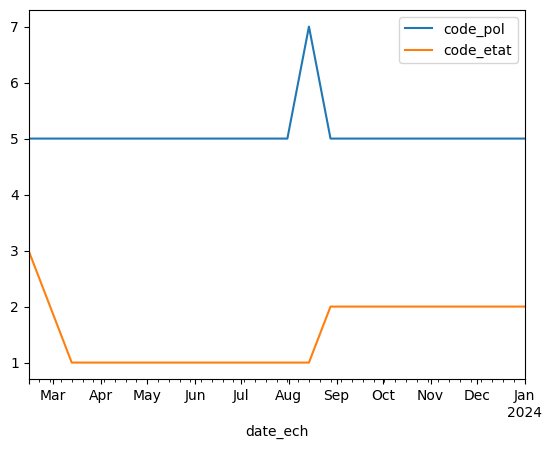

In [356]:
training_set.plot(legend=True)
ax = plt.gca()

In [357]:
from pmdarima import auto_arima

# Pour 'code_etat'
auto_model_code_etat = auto_arima(training_set['code_etat'],
                                  seasonal=True, m=1,  # m est la périodicité saisonnière. Ajustez selon vos données.
                                  trace=True,          # Affiche les modèles testés
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)       # Utilise l'algorithme stepwise

print(auto_model_code_etat.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=23.096, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45.617, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=25.082, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30.562, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=94.021, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=24.293, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=23.806, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=25.267, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=22.906, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=25.627, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=21.855, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=23.824, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=24.079, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=25.095, Time=0.10 sec


In [358]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
p,d,q,P,D,Q,s = 1,1,1,1,1,1,14
# Exemple d'ajustement de modèle pour 'code_etat'
# Remplacer 'training_set' par votre DataFrame d'entraînement
model_code_etat = SARIMAX(training_set['code_pol'], 
                          order=(p, d, q),              
                          seasonal_order=(P, D, Q, s))  
results_code_etat = model_code_etat.fit()

# Prédictions
predictions = results_code_etat.forecast(steps=len(test_set))
print(predictions)


2024-01-15    5.0
2024-01-29    5.0
2024-02-12    5.0
2024-02-26    7.0
2024-03-11    5.0
2024-03-25    5.0
Freq: 14D, Name: predicted_mean, dtype: float64


In [359]:
print(test_set.tail())

            code_pol  code_etat
date_ech                       
2024-01-29       5.0        2.0
2024-02-12       5.0        2.0
2024-02-26       5.0        2.0
2024-03-11       5.0        2.0
2024-03-25       5.0        2.0


In [360]:
def plot_predictions_vs_reel(test_set, predictions):
    """
    Trace les valeurs réelles et prédites de la série temporelle sur le même graphique.
    
    Paramètres :
    - test_set : DataFrame pandas contenant les valeurs réelles de la série temporelle, avec `date_ech` comme index.
    - predictions : Series pandas contenant les valeurs prédites, avec le même index que `test_set`.
    """
    plt.figure(figsize=(10, 6))  # Définir la taille du graphique
    plt.plot(test_set.index, test_set, label='Valeurs Réelles', color='blue', marker='o')  # Trace les valeurs réelles
    plt.plot(test_set.index, predictions, label='Prédictions', color='red', linestyle='--', marker='x')  # Trace les prédictions
    plt.title('Comparaison des Valeurs Réelles et Prédites - Pollution 113 (code_polluant/code etat de la pollution) ')  # Titre du graphique
    plt.xlabel('Date ech')  # Étiquette de l'axe des x
    plt.ylabel('Valeur reelles et prédites')  # Étiquette de l'axe des y
    plt.legend()  # Ajouter une légende
    plt.xticks(rotation=45)  # Rotation des étiquettes de date pour une meilleure lisibilité
    plt.tight_layout()  # Ajuster automatiquement le subplot pour qu'il s'insère dans la zone du graphique
    plt.show()  # Afficher le graphique


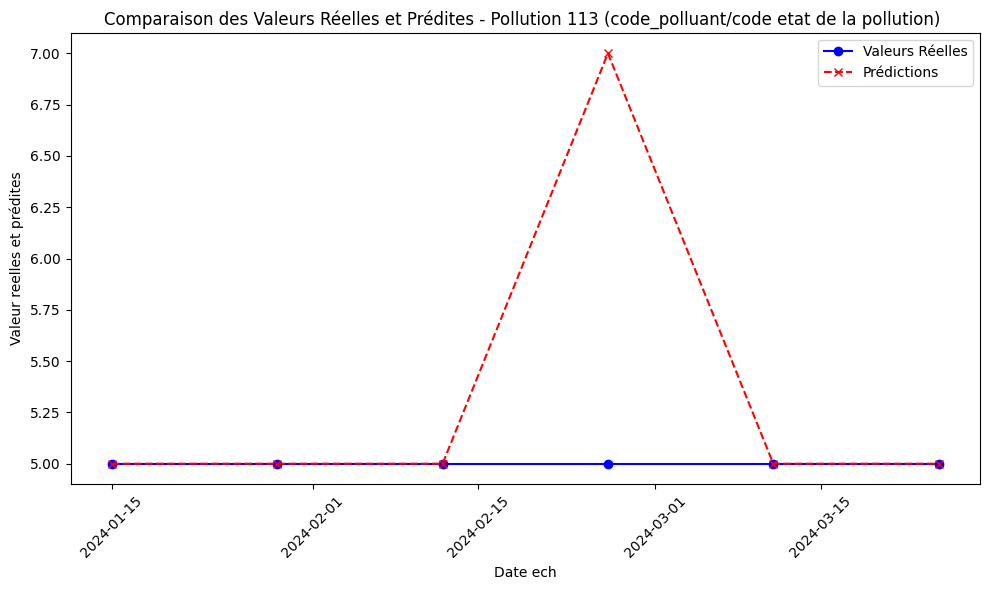

In [361]:
plot_predictions_vs_reel(test_set['code_pol'], predictions)

In [362]:
test_set

,code_pol,code_etat
date_ech,,
2024-01-15,5.0,2.0
2024-01-29,5.0,2.0
2024-02-12,5.0,2.0
2024-02-26,5.0,2.0
2024-03-11,5.0,2.0
2024-03-25,5.0,2.0


### Entrainement du modèle de prédiction de l'état de l'alerte

In [363]:
p,d,q,P,D,Q,s = 1,1,1,1,1,1,14
# Exemple d'ajustement de modèle pour 'code_etat'
# Remplacer 'training_set' par votre DataFrame d'entraînement
model_code_etat = SARIMAX(training_set['code_etat'], 
                          order=(p, d, q),              
                          seasonal_order=(P, D, Q, s))  
results_code_etat = model_code_etat.fit()

# Prédictions
predictions = results_code_etat.forecast(steps=len(test_set)).round()
print(predictions)


rmse = sqrt(mean_squared_error(test_set['code_etat'], predictions))

print(f'RMSE: {rmse}')


2024-01-15    2.0
2024-01-29    2.0
2024-02-12    2.0
2024-02-26    2.0
2024-03-11    3.0
2024-03-25    3.0
Freq: 14D, Name: predicted_mean, dtype: float64
RMSE: 0.5773502691896257


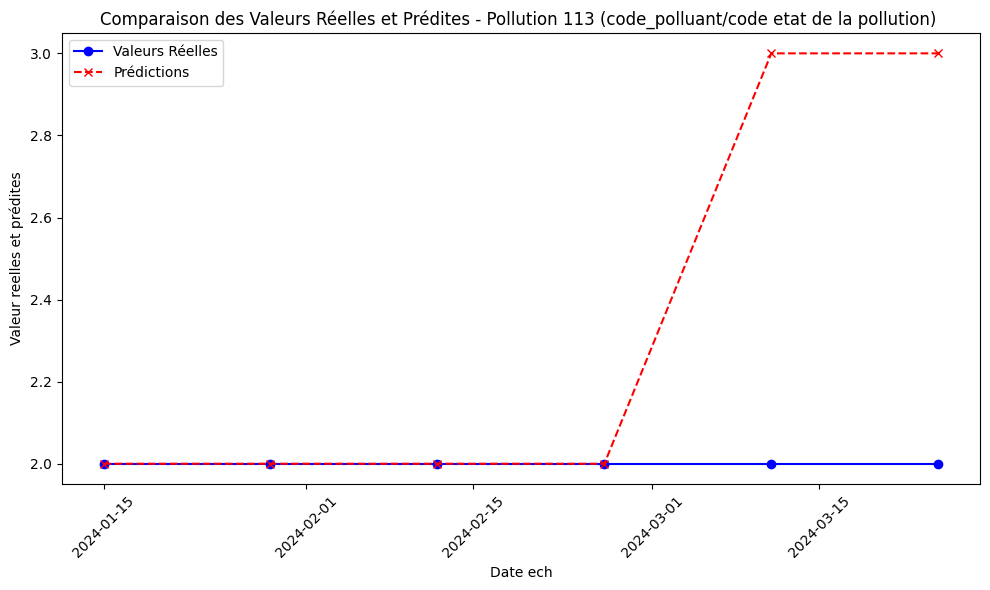

In [364]:
plot_predictions_vs_reel(test_set['code_etat'], predictions)

In [365]:
# Évaluation des prédictions (Exemple : RMSE)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_set['code_pol'], predictions))

print(f'RMSE: {rmse}')

RMSE: 2.70801280154532


<a name="4"></a>
### 4 - Pollution de constaté la veille, le jour même et le lendemain

In [366]:
id_pol = 114
# Choix d'un code zone au hasard
code_zone = "2003"

In [367]:
init_data = get_data_by_dep(polution_114 ,code_zone)

In [368]:
print("dimension des données initiales", init_data.shape)

dimension des données initiales (25, 12)


In [369]:
init_data.head(30)

,_id,gml_id,aasqa,date_maj,partition_field,etat,lib_zone,lib_pol,date_ech,date_dif,code_zone,code_pol
50,65dff5141c41b960f8a839fd,7685164,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,NO2,27/02/2024,26/02/2024,2003,8
72,65dff5141c41b960f8a83a13,7685613,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,PM10,01/03/2024,29/02/2024,2003,5
71,65dff5141c41b960f8a83a12,7685600,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,O3,01/03/2024,29/02/2024,2003,7
70,65dff5141c41b960f8a83a11,7685597,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,NO2,01/03/2024,29/02/2024,2003,8
69,65dff5141c41b960f8a83a10,7685572,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,SO2,29/02/2024,27/02/2024,2003,1
68,65dff5141c41b960f8a83a0f,7685496,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,SO2,29/02/2024,28/02/2024,2003,1
67,65dff5141c41b960f8a83a0e,7685483,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,PM2.5,29/02/2024,28/02/2024,2003,6001
66,65dff5141c41b960f8a83a0d,7685451,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,O3,29/02/2024,27/02/2024,2003,7
65,65dff5141c41b960f8a83a0c,7685446,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,PM2.5,29/02/2024,27/02/2024,2003,6001
64,65dff5141c41b960f8a83a0b,7685444,84,2024-02-28 16:02:13.505000+00:00,842024w9,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,O3,29/02/2024,28/02/2024,2003,7


In [370]:
# Mise à jour des données initiales.
data_pol = update_zone_info(init_data, id_pol, code_zone)

la date la plus recénte avant mise à jour : 2024-02-28 16:02:13.505000+00:00
Les données ont été mises à jour avec succès.
25 récentes observations on été ajouté


In [371]:
data_pol.shape

(50, 12)

In [372]:
# Suppression de la colonne id car crée par mongo
data_pol = data_pol.drop('_id', axis=1)

In [373]:
formated_data = format_pollution(data_pol)

In [299]:
formated_data['code_pol'] = formated_data['code_pol'].replace(6001, 6)

In [300]:
formated_data.tail(5)

,aasqa,date_maj,partition_field,etat,lib_zone,lib_pol,date_ech,date_dif,code_zone,code_pol,code_etat
26,84,2024-03-31 15:00:08.572000+00:00,842024w14,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,O3,2024-04-02,2024/04/01,2003,7,0
25,84,2024-03-31 15:00:08.572000+00:00,842024w13,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,O3,2024-03-30,2024/03/29,2003,7,0
48,84,2024-03-31 15:00:08.572000+00:00,842024w13,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,O3,2024-04-01,2024/03/31,2003,7,0
36,84,2024-03-31 15:00:08.572000+00:00,842024w14,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,PM2.5,2024-04-02,2024/04/01,2003,6,0
49,84,2024-03-31 15:00:08.572000+00:00,842024w14,PAS DE DEPASSEMENT,Bassin Lyon Nord-Isère,SO2,2024-04-02,2024/04/01,2003,1,0


In [301]:
# Échantillonner les dates par fenetre (jour/semaine/mois...), 
fenetre_echantillonage = 14 # on echantillone par mois, mais peut être changé, initialement on a par jour. 
pol_resampled = resample_by_day(formated_data, fenetre_echantillonage)

In [302]:
pol_resampled.shape

(7, 2)

In [303]:
training_set, test_set = split_train_test_set(pol_resampled, 0.2)

In [304]:
training_set = training_set.apply(interpolate)
test_set = test_set.apply(interpolate)

In [305]:
training_set.tail()

,code_pol,code_etat
date_ech,,
2024-01-03,5.0,0.0
2024-01-17,5.0,0.0
2024-01-31,5.0,0.0
2024-02-14,5.0,0.0
2024-02-28,5.0,0.0


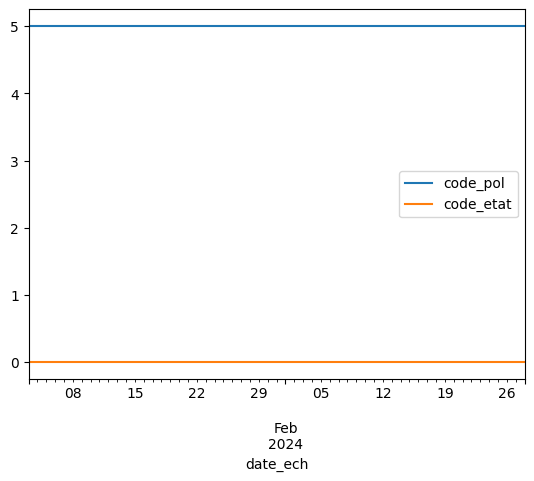

In [306]:
training_set.plot(legend=True)
ax = plt.gca()

In [374]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
p,d,q,P,D,Q,s = 1,1,1,1,1,1,14
# Exemple d'ajustement de modèle pour 'code_etat'
# Remplacer 'training_set' par votre DataFrame d'entraînement
model_code_etat = SARIMAX(training_set['code_pol'], 
                          order=(p, d, q),              
                          seasonal_order=(P, D, Q, s))  
results_code_etat = model_code_etat.fit()

# Prédictions
predictions = results_code_etat.forecast(steps=len(test_set))
print(predictions)


2024-01-15    5.0
2024-01-29    5.0
2024-02-12    5.0
2024-02-26    7.0
2024-03-11    5.0
2024-03-25    5.0
Freq: 14D, Name: predicted_mean, dtype: float64


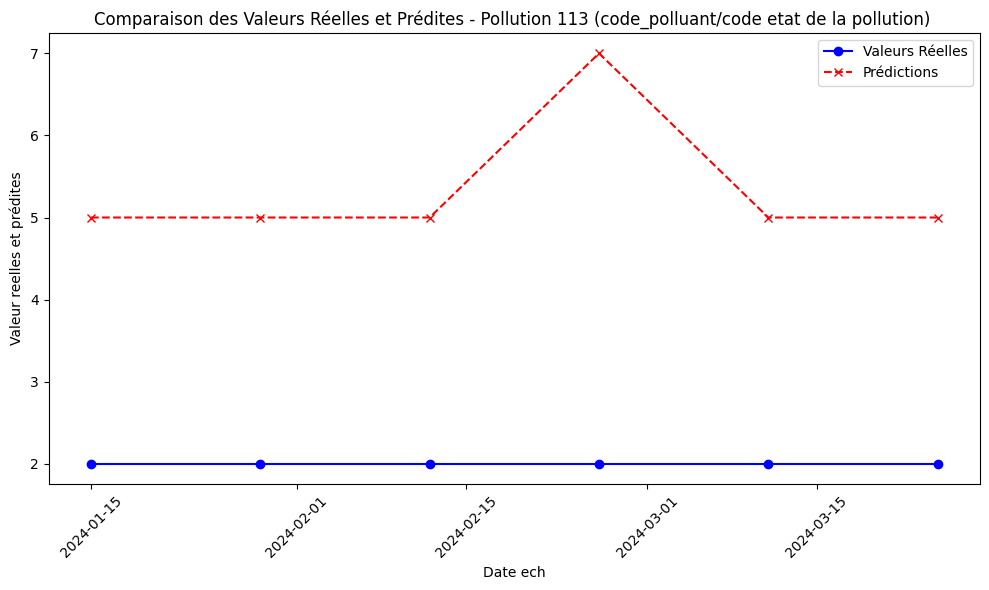

In [375]:
plot_predictions_vs_reel(test_set['code_etat'], predictions)